In [16]:
import numpy as np
import pickle
import time as time
import matplotlib.pyplot as plt
import sys, os
import time as t
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from EEG import EEG
from init_TF import init_TF
from behavior import load_posBin



In [17]:
#torch.manual_seed(1000)
eeg = EEG()
eeg.load('../EEG/1_EEGfilt.mat')
eeg.drop_artifacts()
eeg.drop_electrodes()

nChans, nBins, nElectrodes = 8, 8, 20

basisSet = init_TF(nChans, nBins)

posBin = load_posBin(f'..\\data\\1_Behavior.mat')
posBin = posBin[eeg.art.artInd.transpose()==0]

assert(eeg.eeg.shape == (float(eeg.nTrials - sum(eeg.art.artInd)), nElectrodes, (float(eeg.postTime-eeg.preTime)/4)+1))

In [109]:
class EEGDataset(Dataset):
    def __init__(self, eeg, posBin, tf, time, start=0, end=1):
        s_i, e_i = int(start*eeg.eeg_total().shape[0]), int(end*eeg.eeg_total().shape[0])
        self.data = eeg.eeg_total()[s_i: e_i, :, (time+1000)//4]
        self.label = posBin[s_i: e_i]
        self.tf = tf
    
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx].astype("float32"), self.tf[self.label[idx]].astype('float32')



def data_loader(eeg, posBin, tf, time, batch_size=64):
    train_set = EEGDataset(eeg=eeg, posBin=posBin, tf=tf, time=time, start=0, end=0.7)
    val_set = EEGDataset(eeg=eeg, posBin=posBin, tf=tf, time=time, start=0.7, end=0.85)
    test_set = EEGDataset(eeg=eeg, posBin=posBin,tf=tf, time=time, start=0.85, end=1)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=len(val_set))
    test_loader = DataLoader(test_set, batch_size=len(test_set))

    return train_loader, val_loader, test_loader
    
def train_perceptron(model, eeg, posBin, tf, time, start_time, batch_size=64, verbose=False):
    
    train_loader, val_loader, test_loader = data_loader(eeg, posBin, basisSet, batch_size=64, time=time)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    train_loss = []
    val_loss = []
    total_train_loss = 0.0
    epoch = 0
    while(1):
        epoch += 1
        total_train_loss = 0.0
        for labels, data in test_loader:

            out = model(data.cuda())

            loss = criterion(out, labels.cuda())
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        if epoch == 1:
            train_loss.append(total_train_loss)
        elif total_train_loss<train_loss[-1]:
            train_loss.append(total_train_loss)
        else:
            break
        
        for labels, data in val_loader:
            
            out = model(data.cuda()) 
            loss = criterion(out, labels.cuda())

            val_loss.append(loss.item())
        
        if (verbose):
            print(f"Epoch {epoch}: Training Loss = {train_loss[-1]} | Validation Loss = {val_loss[-1]}")

    sys.stdout.write('\r                                                                   ')
    sys.stdout.write(f'\rTrained Model at timestamp {time} at time {t.time() - start_time} seconds')
    sys.stdout.flush()
    torch.save(model.state_dict(), f'./Trained Models/{time}.pt')
    return train_loss

class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.layer = nn.Linear(8, 20)
        torch.nn.init.xavier_normal_(self.layer.weight)
    def forward(self, x):
        return self.layer(x)


Trained Model at timestamp 100 at time 2.3104560375213623 seconds  

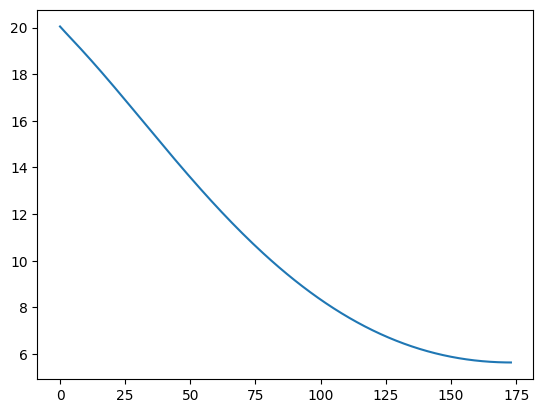

In [19]:
start_time = t.time()
model = Perceptron().cuda()
train_loss = train_perceptron(model, eeg, posBin, tf=basisSet, start_time=start_time, time=100, verbose=False)
plt.plot(train_loss)

In [14]:
train_losses = []
start_time = t.time()
for i in range(-1000, 1749, 4):
    model = Perceptron().cuda()
    train_losses.append(train_perceptron(model, eeg, posBin, batch_size=32, start_time=start_time, tf=basisSet, time=i, verbose=False))

Trained Model at timestamp 1748 at time 1607.0530347824097 seconds 

In [20]:
weights = np.zeros((150, 8, 20))
for t in range(100, 700, 4):
    model = Perceptron()
    model.load_state_dict(torch.load(f'./Trained Models/{t}.pt'))
    weights[int((t-100)/4), :, :] = model.layer.weight.detach().numpy()

ValueError: could not broadcast input array from shape (20,8) into shape (8,20)

In [8]:
toi_start = -500
toi_end = 1249
nBlocks = 3
nTrials = eeg.nTrials - np.sum(eeg.art.artInd)

blocks = np.empty((np.shape(posBin)))

shuffBlocks = np.empty((np.shape(posBin)))

# count number of trials within each position bin
binCnt = np.empty((nBins))
for bin in range(nBins):
    binCnt[bin] = np.sum(1 * np.equal(posBin, bin))

# Data from binCnt: binCnt[0, x] where 0 <= x <= 7

minCnt = min(binCnt)  # No. of trials for position bin with fewest trials

# max No. of trials such that the No. of trials for each bin
# can be equated within each block
nPerBin = int(np.floor(minCnt / nBlocks))

shuffInd = np.array([np.random.permutation(nTrials)]).transpose()  # create shuffle index
shuffBin = posBin[shuffInd.squeeze()]  # shuffle trial order
shuffeeg = eeg.eeg_total()[shuffInd.squeeze(), :, (toi_start+1000)//4:(toi_end+1000)//4]

blocks = []

for block in range(nBlocks):
    blocks.append([])
    for i in range(nBins):
        
        binSpecific = shuffeeg[(posBin==i).squeeze(), :, :]
        average = np.average(binSpecific[0:nPerBin], axis=0)
        blocks[-1].append(average)

blocks = np.array(blocks)

def calculate_C2_at_time_t(time, weights=weights):
    W = weights[int((time-100)/4), :, :]
    y_test = blocks[-1, :, :, (time+1000)//4].transpose()
    y_test = y_test.reshape((y_test.shape[0], -1)).transpose()
    C2 = np.linalg.lstsq(W.conj().transpose(), y_test.conj().transpose(), rcond=None)[0].conj().transpose()
    for i in range(len(C2)):
        C2[i] = (np.roll(C2[i], 1)/np.linalg.norm(C2[i]))
    return C2

In [15]:
activations = np.zeros((150, 8, 8))
for t in range(100, 700, 4):
    activations[int((t-100)/4), :, :] = calculate_C2_at_time_t(t)

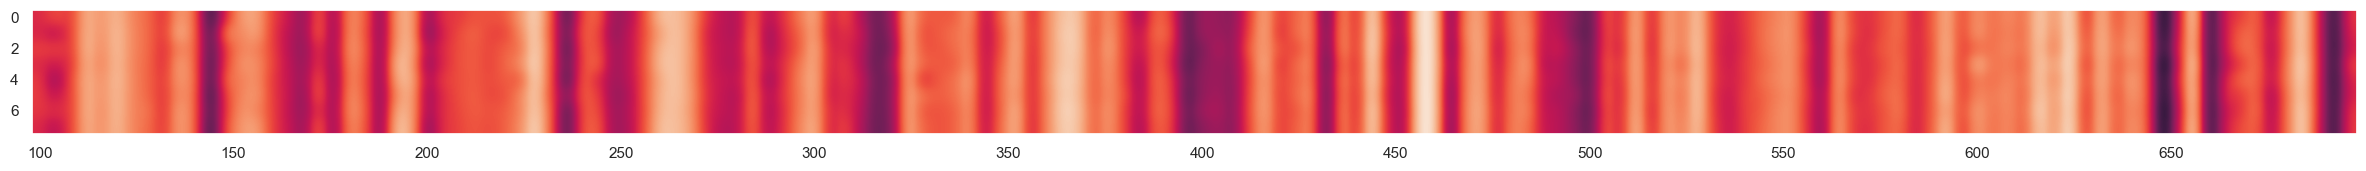

In [17]:
fig, ax = plt.subplots()
plt.grid(False)
plt.xticks(ticks=np.arange(0, 150, 12.5), labels=np.arange(100, 700, 50))
im = ax.imshow(np.mean(activations, axis=1).transpose(), interpolation="quadric")

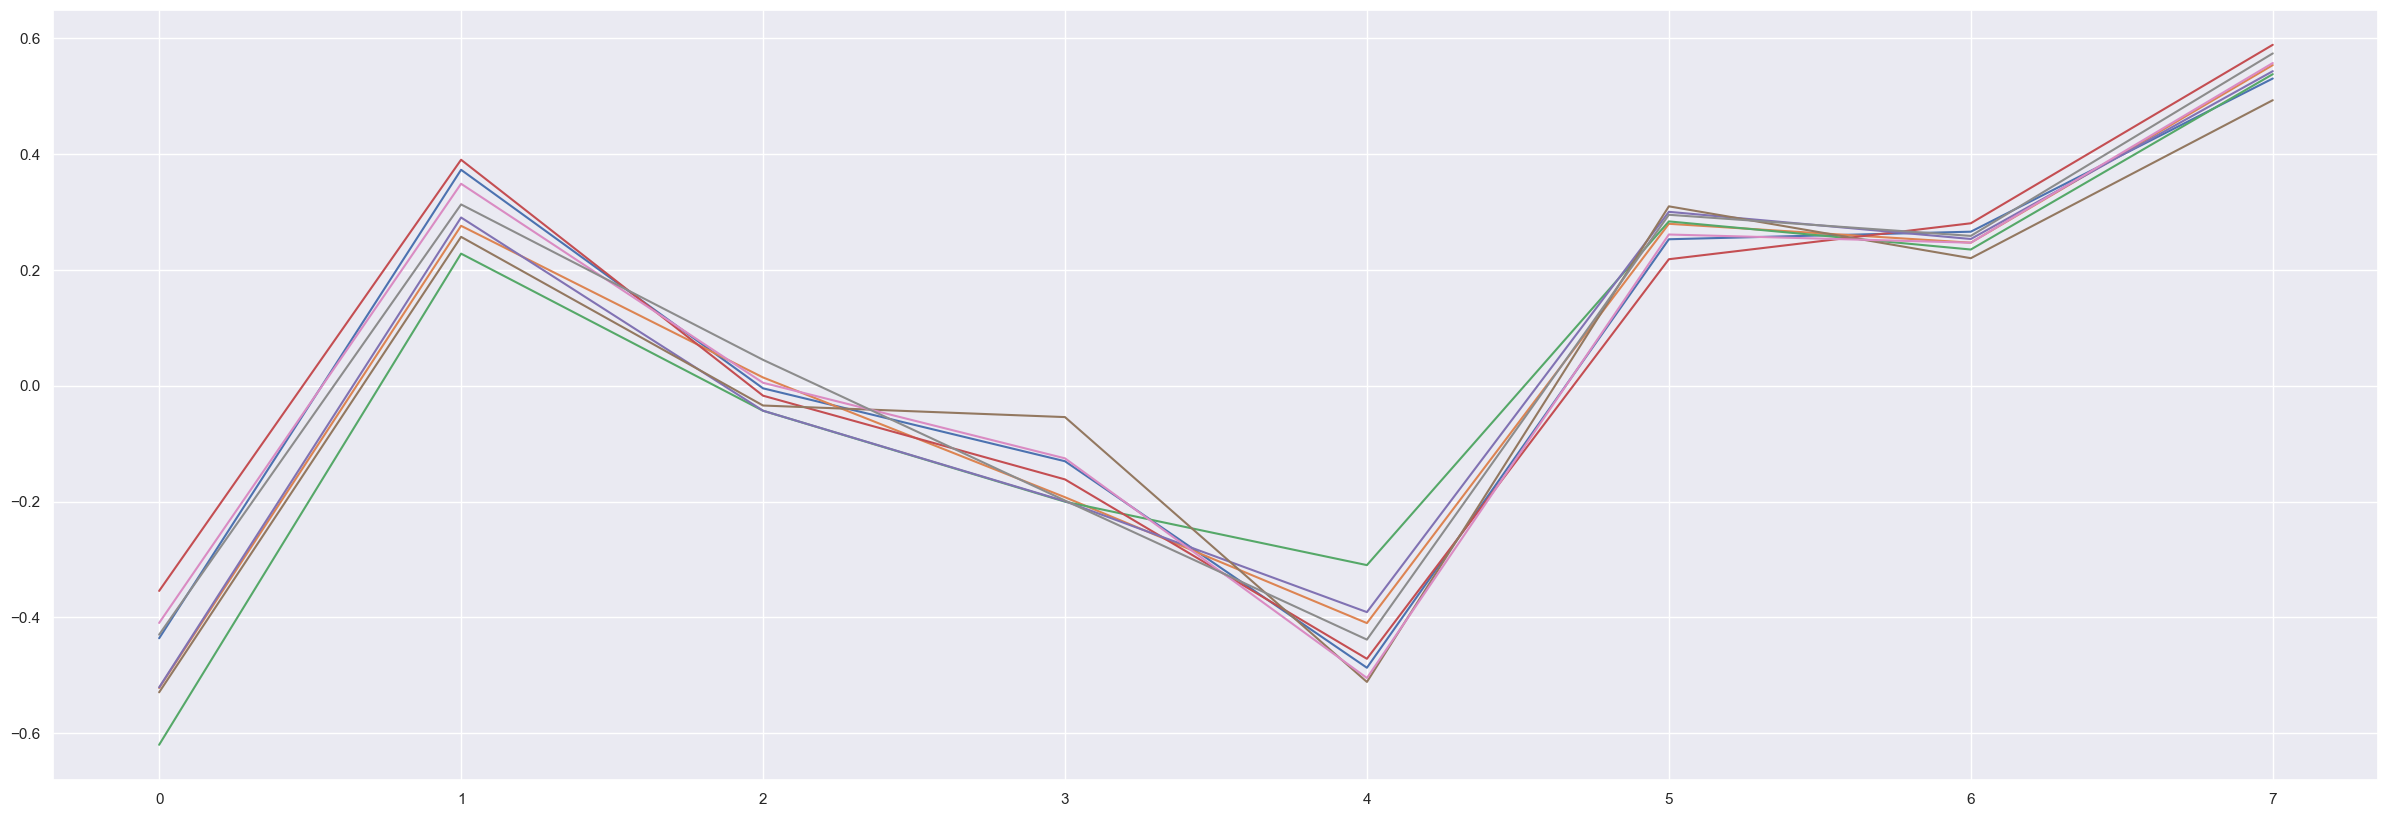

In [14]:
activation = calculate_C2_at_time_t(t)
plt.plot(activation.transpose())

# Trying to overfit to small dataset

In [207]:
class small_dataset(Dataset):
    def __init__(self, eeg, posBin, tf, t):
        toi_start = -500
        toi_end = 1249
        nBlocks = 3
        nTrials = eeg.nTrials - np.sum(eeg.art.artInd)

        blocks = np.empty((np.shape(posBin)))

        shuffBlocks = np.empty((np.shape(posBin)))

        # count number of trials within each position bin
        binCnt = np.empty((nBins))
        for bin in range(nBins):
            binCnt[bin] = np.sum(1 * np.equal(posBin, bin))

        # Data from binCnt: binCnt[0, x] where 0 <= x <= 7

        minCnt = min(binCnt)  # No. of trials for position bin with fewest trials

        # max No. of trials such that the No. of trials for each bin
        # can be equated within each block
        nPerBin = int(np.floor(minCnt / nBlocks))

        shuffInd = np.array([np.random.permutation(nTrials)]).transpose()  # create shuffle index
        shuffBin = posBin[shuffInd.squeeze()]  # shuffle trial order
        shuffeeg = eeg.eeg_total()[shuffInd.squeeze(), :, (toi_start+1000)//4:(toi_end+1000)//4]

        blocks = []

        for block in range(nBlocks):
            blocks.append([])
            for i in range(nBins):
                
                binSpecific = shuffeeg[(posBin==i).squeeze(), :, :]
                average = np.average(binSpecific[0:nPerBin], axis=0)
                blocks[-1].append(average)

        blocks = np.array(blocks)
        blocks = blocks.reshape(24, 20, 437)
        self.data = blocks[:16, :, (t+1000)//4]
        self.label = [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7]
        self.tf = tf
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.tf[posBin[idx]].astype('float32'), self.data[idx].astype('float32')

def small_data_loader(eeg, posBin, tf, t, batch_size):
    return DataLoader(small_dataset(eeg, posBin, tf, t), batch_size=batch_size)

In [145]:
train_loader = small_data_loader(eeg, posBin, basisSet, t, 5)
for data, label in train_loader:
    print(data, label)
    break    

tensor([[1.0000, 0.5745, 0.0884, 0.0012, 0.0000, 0.0012, 0.0884, 0.5745],
        [0.5745, 1.0000, 0.5745, 0.0884, 0.0012, 0.0000, 0.0012, 0.0884],
        [0.0884, 0.0012, 0.0000, 0.0012, 0.0884, 0.5745, 1.0000, 0.5745],
        [1.0000, 0.5745, 0.0884, 0.0012, 0.0000, 0.0012, 0.0884, 0.5745],
        [0.5745, 0.0884, 0.0012, 0.0000, 0.0012, 0.0884, 0.5745, 1.0000]]) tensor([[3.2037, 3.7912, 3.8324, 4.7227, 3.7105, 4.3562, 3.4918, 3.2377, 2.7081,
         3.6017, 2.9898, 3.1007, 1.9718, 3.6859, 2.4529, 4.2166, 4.1143, 4.1320,
         4.5469, 1.9869],
        [3.0461, 3.7860, 3.8089, 3.9232, 3.7064, 4.6053, 3.3775, 3.4427, 2.6811,
         4.0042, 2.9308, 3.2347, 2.0012, 4.3165, 2.2181, 4.4281, 4.1021, 4.4127,
         4.7716, 2.1963],
        [3.6337, 3.9071, 4.1268, 4.8926, 4.7958, 5.0569, 4.2555, 3.3892, 2.7246,
         3.7713, 3.1253, 3.4001, 2.0416, 4.0300, 2.5460, 4.7259, 5.0398, 4.6211,
         5.8544, 2.1520],
        [3.2695, 3.8353, 3.7801, 3.9758, 4.4988, 4.1011, 3.8022, 

Epoch 204: Training Loss = 0.9158580899238586

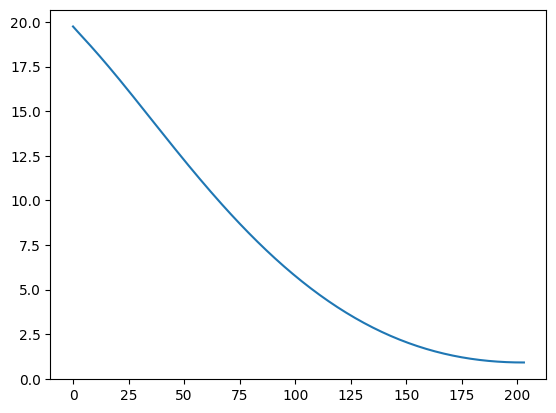

In [212]:
class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.layer = nn.Linear(8, 20)
        #torch.nn.init.xavier_normal_(self.layer.weight)

        self.dropout = nn.Dropout(p=0.9)
    def forward(self, x):
        #self.dropout(x)
        return self.layer(x)


def train_model_small(model, t, epochs, lr, batch_size, verbose=True):
    train_loader = small_data_loader(eeg, posBin, basisSet, t, batch_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss = []
    total_train_loss = 0.0
    epoch = 0
    while(epoch<epochs):
        epoch += 1
        total_train_loss = 0.0
        for data, labels in train_loader:

            out = model(data.cuda())
            
            loss = criterion(out, labels.cuda())
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        if epoch == 1:
            train_loss.append(total_train_loss)
        elif total_train_loss<train_loss[-1]:
            train_loss.append(total_train_loss)
        else:
            break
        
        
        if (verbose):
            sys.stdout.write(f"\rEpoch {epoch}: Training Loss = {train_loss[-1]}")

    return train_loss


model = Perceptron().cuda()
train_losses = train_model_small(model, t=600, epochs=300, lr=0.005, batch_size=20, verbose=True)
plt.plot(train_losses)

Epoch 200: Training Loss = 1.5747845172882084

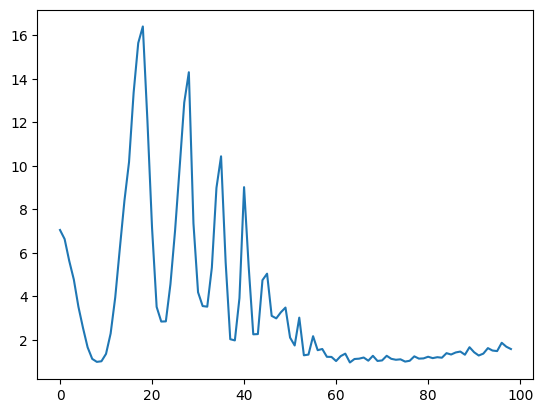

In [160]:
final_loss = []
for i in range(1, 100):
    final_loss.append(train_model_small(model, t=0, epochs=200, lr=0.0001*i, batch_size=20, verbose=True)[-1])
plt.plot(final_loss)

# Trying to overfit on Least Squares

In [97]:
ds = small_dataset(eeg, posBin, basisSet, 0)
A, B = np.zeros((20, 8)), np.zeros((20, 20))
for i in range(len(ds)):
    A[i] = ds[i][0]
    B[i] = ds[i][1]

In [104]:
np.linalg.lstsq(A, B)[0]

array([[ 1.76651761,  2.4649147 ,  2.51814075,  2.09742322,  3.71679537,
         2.22530006,  2.44984039,  1.44350917,  1.50015524,  1.83783228,
         1.74712607,  2.20021049,  2.26629264,  1.95989281,  1.61725812,
         1.60824937,  3.44867484,  2.65561611,  3.34602599,  1.69501184],
       [ 1.99052595,  1.66841298,  1.05051644,  2.87047607,  0.5121427 ,
         2.90353515,  1.58472347,  1.95672676,  1.57325371,  1.88383687,
         1.84438236,  1.26924273,  0.31478832,  1.8618527 ,  1.55383568,
         3.16460913,  1.7425848 ,  1.58983785,  2.83145538,  0.30894602],
       [ 1.09740265,  1.1141329 ,  1.72614757,  0.77279923,  1.93058487,
         1.05909625,  1.46600322,  1.0755371 ,  0.99786424,  1.28017144,
         0.89820134,  0.77838671,  0.49469661,  1.32632252,  0.41787493,
         0.92141195,  1.21047577,  1.7007767 ,  0.87035682,  1.02595456],
       [ 1.83623938,  2.63154391,  2.22925037,  2.86121979,  3.35097101,
         2.74165237,  2.4056786 ,  1.54028373,  